In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# The LIME Example Code

https://nbviewer.jupyter.org/url/arteagac.github.io/blog/lime_image.ipynb
Grabbed everything from this url
Will try to apply the same code to CXR data when a good classifier is trained OR grabbed from some other places 
...


In [ ]:
# need to do this to import inceptionv3 model from keras otherwise there will be error
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 8.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [ ]:
!pip3 install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 9.6 kB/s 
     |████████████████████████████████| 4.0 MB 57.8 MB/s 
     |████████████████████████████████| 1.3 MB 27.4 MB/s 
     |████████████████████████████████| 5.6 MB 35.2 MB/s 
     |████████████████████████████████| 462 kB 60.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Attempting uninstall: tens

In [ ]:

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.6.0


In [ ]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
inceptionV3_model = InceptionV3()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


96116736/96112376 [==============================] - 4s 0us/step


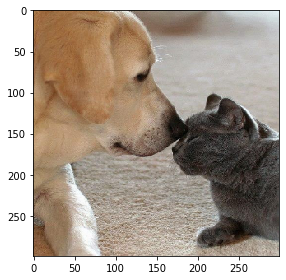

In [ ]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [ ]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes


40960/35363 [==================================] - 0s 0us/step


[('n02099712', 'Labrador_retriever', 0.8273345),
 ('n02099601', 'golden_retriever', 0.014789664),
 ('n02093428', 'American_Staffordshire_terrier', 0.008711364),
 ('n02108422', 'bull_mastiff', 0.008177886),
 ('n02109047', 'Great_Dane', 0.007899425)]

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([208, 207, 180, 243, 246])

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

68

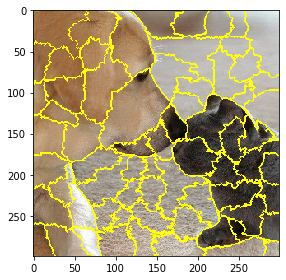

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1])

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

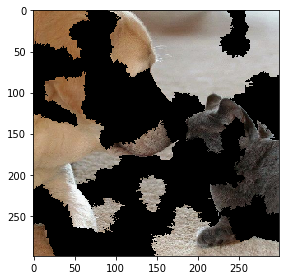

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01998328, -0.01601374,  0.10354324, -0.04821645,  0.08925877,
        0.07826857,  0.02714023,  0.07659394,  0.18122359, -0.05638592,
        0.03509674,  0.00470361,  0.02208911,  0.10356666,  0.072237  ,
        0.00347344,  0.08162886,  0.03907233,  0.00769056,  0.02527207,
       -0.01004943,  0.02130286, -0.07029251, -0.02555164,  0.52121139,
        0.02055341,  0.00131828, -0.17025012, -0.03082532,  0.14881233,
        0.05691059,  0.10112558, -0.01224562, -0.04081403, -0.03864276,
       -0.02153396, -0.05745926,  0.02746972,  0.03796642,  0.03152464,
        0.03358096,  0.00733295,  0.04806799, -0.02303126, -0.01457861,
        0.08431813,  0.00803594, -0.01945883, -0.09000517,  0.05641922,
        0.02874266,  0.01926118, -0.03653451,  0.03901712, -0.05825459,
        0.03474161, -0.10268795,  0.00780906, -0.03470874,  0.03349185,
        0.06900844, -0.05141998,  0.02219387,  0.05436451,  0.0107227 ,
       -0.03208551,  0.09252425, -0.00573777])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([13, 29,  8, 24])

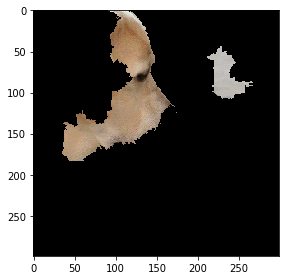

In [ ]:

mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

# Trial for CXR

CheXNet: which is more related to our project 
https://stanfordmlgroup.github.io/projects/chexnet/


*   We develop an algorithm that can detect pneumonia from chest X-rays at a level exceeding practicing radiologists.
*   We train on ChestX-ray14, the largest publicly available chest X- ray dataset.



this one focus on children pneumonia classification
file:///C:/Users/n9784471/Downloads/applsci-10-02908.pdf


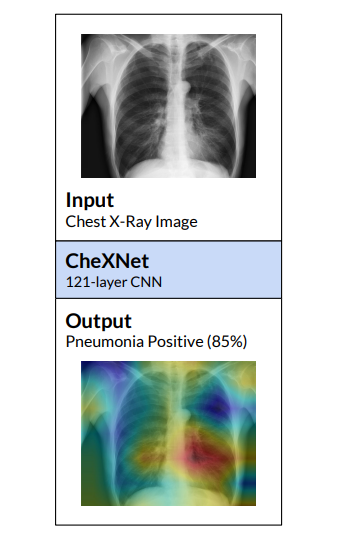

# Use Pre-trained model archtecture and weight for CheXNET

In [ ]:
import os

In [ ]:
import importlib
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model


class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
            NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_names, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(len(class_names), activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [ ]:
# trained model downloaded from this Git
# https://github.com/brucechou1983/CheXNet-Keras
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/trained_models/'

MODEL_FILE_NAME = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

weight_path = os.path.join(DATASET_PATH, MODEL_FILE_NAME)

#print(model_path)

model_fac = ModelFactory()

CLASSES = ['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural_Thickening','Hernia']
#           Atelectasis	Cardiomegaly	Effusion	Infiltration	Mass	Nodule	Pneumonia	Pneumothorax	Consolidation	Edema	Emphysema	Fibrosis	Pleural_Thickening	Hernia
#           Atelectasis	Cardiomegaly	Consolidation	Edema	Effusion	Emphysema	Fibrosis	Hernia	Infiltration	Mass	Nodule	Pleural_Thickening	Pneumonia	Pneumothorax
new_model = model_fac.get_model(class_names = CLASSES,model_name='DenseNet121')

new_model.load_weights(weight_path)

# Check its architecture
new_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________

https://nihcc.app.box.com/v/ChestXray-NIHCC
https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community
CheXNET use this dataset 

Originally used in paper 
https://arxiv.org/pdf/1705.02315v5.pdf

In [ ]:
# test with Chexpert dataset 
# https://nihcc.app.box.com/v/ChestXray-NIHCC
# I have only downloaded the images_001 zip file
import pandas as pd
from glob import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/Chexpert/'
all_xray_df = pd.read_csv(DATASET_PATH + '/Data_Entry_2017_v2020.csv')
chexpert_test_paths = glob(f'{DATASET_PATH}images/*.png')


In [ ]:
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [ ]:
image_idxes = [i[55:] for i in chexpert_test_paths ]

In [ ]:
len(image_idxes)

4999

In [ ]:
filtered_xray_df = all_xray_df[all_xray_df['Image Index'].isin(image_idxes)]

In [ ]:
filtered_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
4994,00001335_002.png,No Finding,2,1335,18,F,PA,2048,2500,0.168,0.168
4995,00001335_003.png,No Finding,3,1335,19,F,PA,2048,2500,0.168,0.168
4996,00001335_004.png,No Finding,4,1335,19,F,PA,2992,2991,0.143,0.143
4997,00001335_005.png,No Finding,5,1335,22,F,PA,2946,2948,0.143,0.143


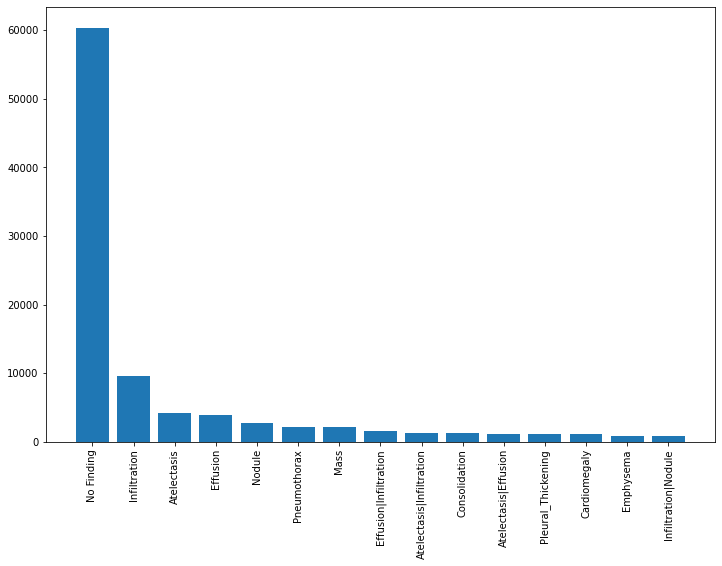

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
filtered_xray_df['Finding Labels'] = filtered_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*filtered_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): \n {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        filtered_xray_df[c_label] = filtered_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
filtered_xray_df

All Labels (14): 
 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,80,M,PA,2500,2048,0.171,0.171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,00001335_002.png,,2,1335,18,F,PA,2048,2500,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4995,00001335_003.png,,3,1335,19,F,PA,2048,2500,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,00001335_004.png,,4,1335,19,F,PA,2992,2991,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,00001335_005.png,,5,1335,22,F,PA,2946,2948,0.143,0.143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
CLASSES = ['Image Index','Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural_Thickening','Hernia']
new_df = filtered_xray_df[CLASSES]


In [ ]:
#mask = filtered_xray_df.Pneumonia == 1
# filtered_xray_df[mask] 
# 65 Pneumonia cases

In [ ]:
from PIL import Image
def get_ground_truth(file_name): 
    mask = new_df['Image Index'] == file_name
    truth = np.array(new_df[mask].iloc[0].to_list()[1:])
    return truth
X_test = []
y_test = []
IMAGE_SIZE = 224

for image_filename in chexpert_test_paths[:10]:
    image = Image.open(image_filename).convert("RGB")
    image = image.resize((IMAGE_SIZE,IMAGE_SIZE))
    image = np.array(image) / 224.
    X_test.append(image)
    y_test.append(get_ground_truth(image_filename[55:]))

In [ ]:
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
print(X_test.shape)
print(y_test.shape)

(10, 224, 224, 3)
(10, 14)


In [ ]:

new_model.compile(optimizer = "adam", loss = 'categorical_crossentropy')
new_model.load_weights(weight_path)
new_model.evaluate(X_test, y_test)

#print("Loss: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\n" %(loss_val, acc_val, prec_val, rec_val) )

10/10 [==============================] - 6s 567ms/step


5.529596328735352

In [ ]:
preds = []
groundtruths = []
for indx in range(0, X_test.shape[0]):
  
  image_test = X_test[indx].reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3) 
  prediction = np.argmax(new_model.predict( image_test ))
  groundtruths.append(np.argmax(y_test[indx]))
  preds.append(prediction)

In [ ]:
CLASSES = ['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural_Thickening','Hernia']

from sklearn.metrics import classification_report
report = classification_report(groundtruths, preds, target_names=CLASSES)
print(report) 

# Train my own classifier

In [ ]:
# models will be trained from another notebook and saved in my google drive
# load classifier
import tensorflow as tf
from tensorflow import keras

PATH = '/content/drive/MyDrive/Colab Notebooks/Data/Pneumonia-Detection-using-Deep-Learning-main/'
METRICS = ['accuracy' , tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

IMAGE_SIZE = 180






def load_model_history( model_name, path):
    model_hist_loaded = {}
    values = []

    # load dictionary
    r = open( path + model_name + "_hist.csv", "r").read()
    for line in r.split("\n"):
        if(len(line) == 0):
            continue
  
        metric = line.split(",\"[")[0]                                    # extract metrics
        values_str = line.split(",\"[")[1].replace("]\"","").split(", ")  # extract validation values
        values = [float(val_str) for val_str in values_str]
        model_hist_loaded.update( {metric : values} )
    
    return model_hist_loaded

def load_model( model_name, path ):
    json_file = open( path + model_name +  "_DUO.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    # load weights into new model
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(path + model_name +  "_DUO.h5")
    print("Loaded model from disk")
    
    return loaded_model


In [ ]:
from keras.models import model_from_json
model_history = load_model_history('/final_hist_DenseNet_'+str(IMAGE_SIZE), PATH)
model_dense = load_model('/final_DenseNet_'+str(IMAGE_SIZE), PATH)
model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
model_dense.summary()


Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________________________________________________

# Use VinDr-CXR

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import os
# load a image of vindr
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/annotations/'
TEST_CSV = os.path.join(DATASET_PATH, "image_labels_test.csv")
test_df = pd.read_csv(TEST_CSV)
#global_labels = ['image_id', 'Pneumonia', 'No finding']
df_global = test_df#[global_labels]

In [ ]:
 temp_df = df_global.loc[df_global['Pneumonia'] == 1]
 pneu_df = temp_df.loc[temp_df['No finding'] == 0]
 pneu_df = pneu_df.drop_duplicates()
 pneu_df

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,ILD,Infiltration,Lung Opacity,Lung cavity,Lung cyst,Mediastinal shift,Nodule/Mass,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other disease,No finding
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
12,934e2731a86f3a6d750f7f7d9eaea85c,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
17,6cbbbc0e77251e60d6f4af673cc19e2a,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
18,9b609fc8e82081f4ac5bf83b8a0fbc5c,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,48fcc25810228823538d0392877fcce0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
974,f6fa36dcae4cfd831f6d5a6bd4520a59,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0
977,56e3aa531cd2b4c2a597657ce69bea4f,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
981,074e3cceb0c1677a1ad0dbff31167d7d,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
normal_list = normal_df['image_id'].tolist()
normal_list

In [ ]:
'''
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

for i in normal_list:

  test_img = '/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/test/' + i +'.png'
  image = Image.open(test_img).convert("RGB")
  image.save('/content/drive/MyDrive/Colab Notebooks/Data/Pneumonia-Detection-using-Deep-Learning-main/chest_xray/vindr/NORMAL/' + i +'.png')
#output.save(test_path.replace('dicom', 'png'))
'''

In [ ]:
normal_df = df_global.loc[df_global['No finding'] == 1].drop_duplicates()
normal_df = normal_df[:246]
normal_df

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,ILD,Infiltration,Lung Opacity,Lung cavity,Lung cyst,Mediastinal shift,Nodule/Mass,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other disease,No finding
15,5c55f871429730b84a8ee275839b8aae,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
29,4dcaf539b6497ad02f2734e1b78c9678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
60,58baa9b0269a2987f5475a554033c4b1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
62,36aa7cdf317c33edc514ef43814d4c9b,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
137,69fa47c3c46618fe8c58966a2cc66aef,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,4783897bac1d991d9a95f8c6bdb14766,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1191,19d24dee80c92094175c10817959c5fa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1192,9d68356f37f8ed3cdea24fcf8392b028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1193,1c41827efd6e236f8b05c6524f1a43c3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
frames = [pneu_df, normal_df]

In [ ]:
df_global = pd.concat(frames)

In [ ]:
df_global

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,ILD,Infiltration,Lung Opacity,Lung cavity,Lung cyst,Mediastinal shift,Nodule/Mass,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other disease,No finding
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
12,934e2731a86f3a6d750f7f7d9eaea85c,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
17,6cbbbc0e77251e60d6f4af673cc19e2a,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
18,9b609fc8e82081f4ac5bf83b8a0fbc5c,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,4783897bac1d991d9a95f8c6bdb14766,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1191,19d24dee80c92094175c10817959c5fa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1192,9d68356f37f8ed3cdea24fcf8392b028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1193,1c41827efd6e236f8b05c6524f1a43c3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_global['image_id'].iloc[13]

In [ ]:
def get_ground_truth(file_name): 
    mask = df_global['image_id'] == file_name
    truth = np.array(df_global[mask].iloc[0].to_list()[1:])


    return truth

PREDICTION = Pneumonia
GROUNDTRUTH = Pneumonia


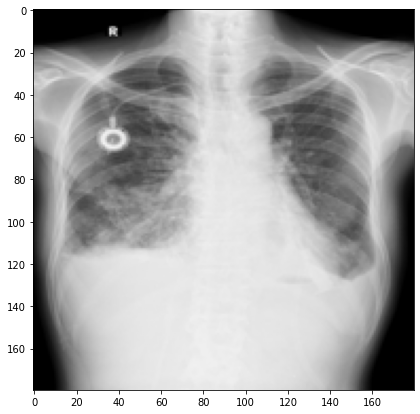

In [ ]:
test_path = '/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/test/'

global_labels = ['Pneumonia', 'Normal']

INDEX = 1
test_file_path = test_path + df_global['image_id'].iloc[INDEX] + '.png'
IMAGE_SIZE = 180

image = Image.open(test_file_path ).convert("RGB")
image = image.resize((IMAGE_SIZE, IMAGE_SIZE)) 
image_raw = np.array(image) / 255.
image = image_raw[ np.newaxis, ... ]

plt.figure(figsize=(7,7)) 
plt.imshow(image_raw)

prediction = np.argmax(model_dense.predict( image ))
groundtruth = "Pneumonia"#""global_labels[np.argmax(get_ground_truth(df_global['image_id'].iloc[INDEX]))]

CLASSES = ['Pneumonia','Normal']
print("PREDICTION = " + CLASSES[prediction])
print("GROUNDTRUTH = " + groundtruth)

In [ ]:
test_file_path 

'/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/test/0aed23e64ebdea798486056b4f174424.png'

# Apply LIME to the CXR 

In [ ]:
# change the file path and plot it
image = Image.open(test_file_path ).convert("RGB")
image = image.resize((180, 180)) 
image = np.array(image) / 255.
image_raw = image_raw[ np.newaxis, ... ]
Xi = image_raw

In [ ]:
# update the model and get prediction for our target CXR image data
np.random.seed(222)
preds = model_dense.predict(Xi)
preds[0][0] 

1.0

In [ ]:
# generate the superpixels for cxr
superpixels = skimage.segmentation.quickshift(image, kernel_size=3,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

32

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

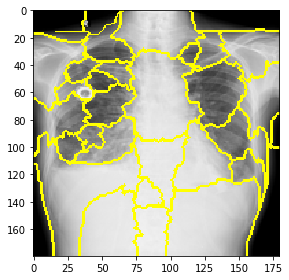

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(image, superpixels))
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

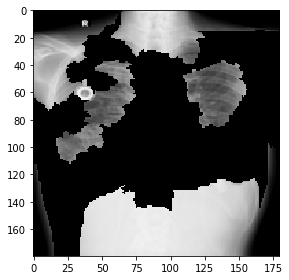

In [ ]:
skimage.io.imshow(perturb_image(image,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(image,pert,superpixels)
  pred = model_dense.predict(perturbed_img[ np.newaxis, ... ])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes 

array([0])

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.00046833, -0.00137498,  0.00057092, -0.0026368 , -0.00284275,
       -0.0011286 ,  0.00099519, -0.00135254, -0.00415563,  0.00083647,
       -0.00068643, -0.00132817, -0.00152908,  0.00046731, -0.00047514,
        0.00066617,  0.00049578,  0.00308111,  0.00171363,  0.00123345,
        0.00032667,  0.00079175,  0.00092278,  0.00045303,  0.00030551,
        0.0012597 ,  0.00017799,  0.00086431, -0.00054317, -0.00032634,
       -0.00030514,  0.00153812])

In [ ]:
num_top_features = 6
top_features = np.argsort(coeff)[-num_top_features:] 
top_features


array([ 6, 19, 25, 31, 18, 17])

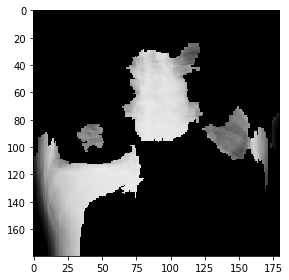

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(image,mask,superpixels) )

# Apply Bounding Boxes

In [ ]:
# Define Path 
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

INDEX = 1

PATH = '/content/drive/MyDrive/Colab Notebooks/'
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/VinDr_CXR/annotations/'

# Define paths to the relevant csv files
TEST_LOCAL_CSV = os.path.join(DATASET_PATH, "annotations_test.csv")
test_local_df = pd.read_csv(TEST_LOCAL_CSV)

target_file = df_global['image_id'].iloc[INDEX] 
#target_file = png_test_paths[INDEX][55:-4]
mask = test_local_df['image_id'] == target_file
test_local_df[mask]

,image_id,class_name,x_min,y_min,x_max,y_max
8,0aed23e64ebdea798486056b4f174424,Pleural effusion,1593.050179,1885.493865,2164.350008,2288.954196
9,0aed23e64ebdea798486056b4f174424,Pleural effusion,162.061085,1757.177093,881.412855,2229.059285
10,0aed23e64ebdea798486056b4f174424,Infiltration,315.601404,1083.708875,929.248181,1761.497249
11,0aed23e64ebdea798486056b4f174424,Consolidation,453.981594,1364.891284,871.027043,1738.592121


In [ ]:
class_names = test_local_df['class_name'].unique() #  unique names - here we only need my finding list values 

# map label_id to specify color 
# and specify thicknes and scale we want to use for each img
label2color = {class_name:[randint(0,255) for i in range(3)] for class_name in class_names}
label2color

{'Aortic enlargement': [194, 207, 196],
 'Atelectasis': [182, 50, 79],
 'Calcification': [96, 205, 12],
 'Cardiomegaly': [147, 95, 169],
 'Clavicle fracture': [152, 66, 134],
 'Consolidation': [180, 134, 211],
 'Emphysema': [186, 201, 185],
 'Enlarged PA': [161, 99, 124],
 'ILD': [79, 106, 76],
 'Infiltration': [198, 162, 112],
 'Lung Opacity': [30, 3, 111],
 'Lung cavity': [71, 105, 108],
 'Lung cyst': [91, 4, 82],
 'Mediastinal shift': [229, 234, 137],
 'No finding': [197, 140, 23],
 'Nodule/Mass': [252, 143, 115],
 'Other lesion': [210, 229, 159],
 'Pleural effusion': [175, 130, 77],
 'Pleural thickening': [141, 224, 140],
 'Pneumothorax': [84, 185, 118],
 'Pulmonary fibrosis': [227, 225, 251],
 'Rib fracture': [244, 16, 233]}

In [ ]:
# shape (2555, 2285)
# 2880, 2304
# (2430, 1994)
#2880, 2304
target_coor_df = test_local_df[mask]
original_image_width = 2304
original_image_height = 2880

reshaped_image_width = 256
reshaped_image_height = 256
def get_resized_coordinates(lst):
    lst[0] = lst[0] / original_image_width
    lst[1] = lst[1] / original_image_height
    lst[2] = lst[2] / original_image_width
    lst[3] = lst[3] / original_image_height

    lst[0] = lst[0] * reshaped_image_width
    lst[1] = lst[1] * reshaped_image_height
    lst[2] = lst[2] * reshaped_image_width
    lst[3] = lst[3] * reshaped_image_height

    return lst

boxes = target_coor_df.loc[target_coor_df['image_id'] == target_file, ['x_min', 'y_min', 'x_max', 'y_max']].values
resized_boxes = [ get_resized_coordinates(box) for box in boxes ]
resized_boxes

[array([177.00557541, 167.59945468, 240.48333418, 203.46259524]),
 array([ 18.00678724, 156.19351937,  97.93476171, 198.13860312]),
 array([ 35.06682263,  96.3296778 , 103.24979789, 156.57753323]),
 array([ 50.44239933, 121.32366968,  96.7807825 , 154.54152189])]

In [ ]:
labels = target_coor_df['class_name'].to_list()
labels

['Pleural effusion', 'Pleural effusion', 'Infiltration', 'Consolidation']

In [ ]:
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


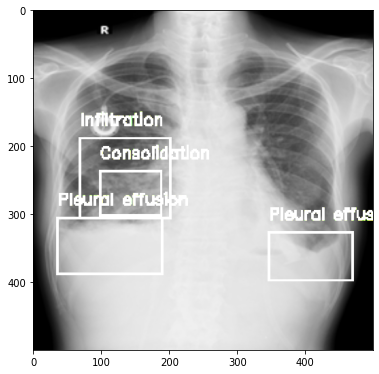

In [ ]:
imgs = []

image = Image.open( test_path + df_global['image_id'].iloc[INDEX] + '.png')
img = np.array(image) / 255.
img = np.stack([img, img, img], axis=-1)

thickness = 1
for label, box in zip(labels, resized_boxes):
    color = label2color[label]
    img = cv2.rectangle(
        img,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        color, thickness
        )
    img = cv2.putText(img, label, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (36,255,12), 1)

img = cv2.resize(img, (256,256))
imgs.append(img)
    
plot_imgs(imgs)

# Apply Grad-Cam